Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Suppress warnings to keep notebook output clean and readable
import warnings
warnings.filterwarnings("ignore")

# Core scientific and data manipulation libraries
import numpy as np                  # Numerical computing
import pandas as pd                # DataFrame operations and data loading
import matplotlib.pyplot as plt    # Plotting and visualizations
import seaborn as sns              # Statistical visualizations built on top of matplotlib
import time                        # Timing operations (training/prediction speed)

# Type hints for cleaner function signatures
from typing import Tuple, List, Dict

# Scikit-learn utilities for splitting data, preprocessing, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer               # Handling missing values
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer          # Combine numeric + categorical pipelines
from sklearn.pipeline import Pipeline                  # Build end-to-end ML pipelines
from sklearn.metrics import mean_squared_error         # RMSE evaluation

# Regression models used for comparison
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Optional: LightGBM (fast gradient boosting)
try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    # LightGBM is optional; warn the user if it's missing
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not found. Install with `pip install lightgbm` to use it.")

In [2]:
# ------------------------------------
# Helper: Load data file
# ------------------------------------
def load_data(path: str) -> pd.DataFrame:
    """
    Load the car data from a CSV file with basic error handling.

    Parameters
    ----------
    path : str
        File path to the CSV dataset.

    Returns
    -------
    pd.DataFrame
        The loaded dataset as a pandas DataFrame.

    Raises
    ------
    FileNotFoundError
        If the file path does not exist.
    ValueError
        If the file exists but is empty or corrupted.
    RuntimeError
        For any other unexpected read errors.
    """
    try:
        # Attempt to read the CSV file into a DataFrame
        df = pd.read_csv(path)

    except FileNotFoundError:
        # Raised when the file path is incorrect or missing
        raise FileNotFoundError(f"File not found at path: {path}")

    except pd.errors.EmptyDataError:
        # Raised when the file exists but contains no readable data
        raise ValueError("The file is empty or corrupted.")

    except Exception as e:
        # Catch-all for any other unexpected issues during file loading
        raise RuntimeError(f"Unexpected error while reading CSV: {e}")

    # Return the successfully loaded DataFrame
    return df

In [3]:
def eda_report(df: pd.DataFrame, target_col: str = "Price") -> None:
    """
    Generate a compact exploratory data analysis (EDA) summary for a DataFrame.

    This report provides:
    - Dataset structure and column types
    - Missing value percentages for each column
    - Summary statistics for numeric features
    - Summary statistics for the target column (if present)

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to analyze.
    target_col : str, optional
        Name of the target column for additional summary statistics.
    """

    # Display basic structural information:
    # column names, data types, non-null counts, and memory usage.
    print("\n=== EDA: Info ===")
    df.info()

    # Calculate and display the fraction of missing values per column.
    # Sorting helps quickly identify the most problematic features.
    print("\n=== EDA: Missing values (fraction) ===")
    missing = df.isna().mean().sort_values(ascending=False)
    print(missing)

    # Show descriptive statistics for all numeric columns:
    # count, mean, std, min, quartiles, and max.
    print("\n=== EDA: Numeric describe ===")
    print(df.describe())

    # If the target column exists, print its own descriptive statistics.
    # This helps understand the distribution of the prediction target.
    if target_col in df.columns:
        print("\n=== EDA: Target describe ===")
        print(df[target_col].describe())

In [4]:
def plot_distributions(df: pd.DataFrame, numeric_cols: List[str], target_col: str = "Price") -> None:
    """
    Plot histogram distributions for all numeric features and (optionally) the target column.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset containing the features to visualize.
    numeric_cols : List[str]
        List of numeric feature names to plot.
    target_col : str, optional
        Name of the target column to include in the plots if present.

    Notes
    -----
    Histograms help reveal:
    - Skewed distributions
    - Outliers
    - Data ranges and density
    - Whether transformations (e.g., log) may be useful
    """

    # Make a copy of the numeric column list so we don't modify the original
    cols = numeric_cols.copy()

    # Include the target column if it exists and isn't already included
    if target_col in df.columns and target_col not in cols:
        cols.append(target_col)

    # Generate a histogram for each selected column
    for col in cols:
        plt.figure(figsize=(6, 4))  # Set a consistent figure size
        df[col].hist(bins=50)       # Use 50 bins for a smoother distribution curve
        plt.title(f"Distribution of {col}")  # Title for clarity
        plt.xlabel(col)             # Label the x-axis with the feature name
        plt.ylabel("Count")         # Label the y-axis with the frequency count
        plt.tight_layout()          # Prevent label overlap
        plt.show()                  # Display the plot

In [5]:
def plot_correlations(df: pd.DataFrame, numeric_cols: List[str], target_col: str = "Price") -> None:
    """
    Plot a correlation heatmap for numeric features and (optionally) the target column.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset containing the features to analyze.
    numeric_cols : List[str]
        List of numeric feature names to include in the correlation matrix.
    target_col : str, optional
        Name of the target column to include if present.

    Notes
    -----
    Correlation heatmaps help identify:
    - Linear relationships between numeric variables
    - Redundant or highly correlated features
    - Potential predictors of the target variable
    """

    # Filter numeric columns to ensure they exist in the DataFrame.
    # This prevents errors if the list contains outdated or missing columns.
    cols = [c for c in numeric_cols if c in df.columns]

    # Include the target column if it exists and isn't already included.
    if target_col in df.columns and target_col not in cols:
        cols.append(target_col)

    # Compute the correlation matrix for the selected columns.
    corr = df[cols].corr()

    # Create a heatmap visualization of the correlation matrix.
    plt.figure(figsize=(10, 8))          # Larger figure for readability
    sns.heatmap(corr, annot=False, cmap="coolwarm")  # 'coolwarm' highlights positive/negative correlations
    plt.title("Correlation heatmap")     # Title for clarity
    plt.tight_layout()                   # Prevent label overlap
    plt.show()                           # Display the plot

In [6]:
def plot_outliers(df: pd.DataFrame, numeric_cols: List[str]) -> None:
    """
    Generate boxplots for numeric features to visually inspect potential outliers.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset containing the numeric features.
    numeric_cols : List[str]
        List of numeric column names to visualize.

    Notes
    -----
    Boxplots help identify:
    - Extreme values (outliers)
    - Distribution spread (IQR)
    - Skewness or asymmetry in the data
    """

    # Loop through each numeric column and create an individual boxplot
    for col in numeric_cols:
        plt.figure(figsize=(6, 4))      # Consistent figure size for readability
        sns.boxplot(x=df[col])          # Boxplot of the selected numeric column
        plt.title(f"Boxplot of {col}")  # Clear title for the plot
        plt.tight_layout()              # Prevent label and layout overlap
        plt.show()                      # Display the plot

In [7]:
def clean_data(df: pd.DataFrame, target_col: str = "Price") -> pd.DataFrame:
    """
    Clean the car dataset by applying several sanity checks and preprocessing steps.

    Operations performed:
    - Remove rows with missing target values
    - Convert date columns to datetime
    - Drop columns known to be unhelpful or misleading
    - Apply numeric sanity filters (e.g., valid registration years)
    - Replace impossible numeric values with NaN
    - Remove invalid target values and clip extreme outliers

    Parameters
    ----------
    df : pd.DataFrame
        Raw dataset to clean.
    target_col : str, optional
        Name of the target column (default: "Price").

    Returns
    -------
    pd.DataFrame
        A cleaned and sanitized version of the dataset.
    """

    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Remove rows where the target is missing
    # These rows cannot be used for supervised learning
    df = df.dropna(subset=[target_col])

    # Convert known date columns to datetime format
    # Invalid formats become NaT (handled later if needed)
    date_cols = ["DateCrawled", "DateCreated", "LastSeen"]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # Drop columns known to be unhelpful or misleading
    # NumberOfPictures is always zero in this dataset
    # PostalCode is too granular and often missing
    cols_to_drop = [
        "NumberOfPictures",
        "PostalCode"
    ]
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Apply basic numeric sanity checks

    # RegistrationYear: keep only plausible years
    if "RegistrationYear" in df.columns:
        df = df[(df["RegistrationYear"] >= 1950) & (df["RegistrationYear"] <= 2025)]

    # Power: replace impossible horsepower values with NaN
    if "Power" in df.columns:
        df.loc[(df["Power"] <= 20) | (df["Power"] > 1000), "Power"] = np.nan

    # Mileage: replace impossible mileage values with NaN
    if "Mileage" in df.columns:
        df.loc[(df["Mileage"] <= 0) | (df["Mileage"] > 1_000_000), "Mileage"] = np.nan

    # Target sanity checks:
    # - Remove zero or negative prices
    # - Clip extreme outliers at the 99th percentile
    df = df[df[target_col] > 0]
    upper_price = df[target_col].quantile(0.99)
    df[target_col] = np.clip(df[target_col], 0, upper_price)

    return df

In [8]:
def engineer_features(df: pd.DataFrame, target_col: str = "Price") -> pd.DataFrame:
    """
    Create additional engineered features to enhance model performance.

    Features added:
    - LogPrice : log-transformed target to stabilize variance and reduce skew
    - CarAge   : approximate age of the vehicle based on registration year
                 and the most reliable available reference year

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to augment with engineered features.
    target_col : str, optional
        Name of the target column (default: "Price").

    Returns
    -------
    pd.DataFrame
        A new DataFrame containing the original data plus engineered features.
    """

    # Work on a copy to avoid modifying the original dataset
    df = df.copy()

    # ---------------------------------------------------------
    # 1. Log-transform the target variable
    # ---------------------------------------------------------
    # Log1p handles zero values safely (log(1 + x)).
    # This transformation often improves model stability and performance.
    if target_col in df.columns:
        df["LogPrice"] = np.log1p(df[target_col])

    # ---------------------------------------------------------
    # 2. Estimate a reference year for computing CarAge
    # ---------------------------------------------------------
    # Priority:
    #   1. Use DateCreated if available
    #   2. Else use LastSeen
    #   3. Else fall back to a fixed reference year (2016)
    ref_year = 2016  # fallback default

    if "DateCreated" in df.columns and df["DateCreated"].notna().any():
        # Extract year from DateCreated, filling missing values with fallback
        ref_year = df["DateCreated"].dt.year.fillna(ref_year)

    elif "LastSeen" in df.columns and df["LastSeen"].notna().any():
        # Extract year from LastSeen, filling missing values with fallback
        ref_year = df["LastSeen"].dt.year.fillna(ref_year)

    # ---------------------------------------------------------
    # 3. Compute CarAge using RegistrationYear
    # ---------------------------------------------------------
    if "RegistrationYear" in df.columns:

        # If ref_year is a Series (derived from DateCreated/LastSeen),
        # subtract element-wise. Otherwise subtract scalar fallback.
        df["CarAge"] = ref_year - df["RegistrationYear"]

        # Remove impossible or unrealistic ages:
        # - Negative ages (future registration)
        # - Ages over 80 years (extreme outliers)
        df.loc[(df["CarAge"] < 0) | (df["CarAge"] > 80), "CarAge"] = np.nan

    return df

In [9]:
def train_and_evaluate(model_name, model, preprocessor):
    """
    Train a regression model inside a preprocessing pipeline and compute RMSE.

    Notes
    -----
    - Training and prediction timing are handled externally using Jupyter magics
      (%time, %%time, %timeit), so this function focuses solely on correctness.
    - The target variable is assumed to be log-transformed (LogPrice), so
      predictions are exponentiated back to the original price scale.

    Parameters
    ----------
    model_name : str
        A label used for printing and reporting results.
    model : estimator
        Any scikit-learn compatible regression model.
    preprocessor : ColumnTransformer
        Preprocessing pipeline for numeric and categorical features.

    Returns
    -------
    pipe : Pipeline
        The fitted scikit-learn pipeline (preprocessing + model).
    rmse : float
        Root Mean Squared Error computed on the validation set.
    """

    # Header for readability in notebook output
    print(f"\n=== {model_name} ===")

    # Build a full pipeline that applies preprocessing first,
    # then fits the regression model.
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # -----------------------------
    # Fit the model (timed externally)
    # -----------------------------
    pipe.fit(X_train, y_train)

    # -----------------------------
    # Predict on validation data
    # (timed externally)
    # -----------------------------
    y_pred_log = pipe.predict(X_valid)

    # -----------------------------
    # Convert predictions back from log scale
    # -----------------------------
    y_valid_price = np.expm1(y_valid)       # Ground truth in original scale
    y_pred_price = np.expm1(y_pred_log)     # Model predictions in original scale

    # -----------------------------
    # Compute RMSE in real price units
    # -----------------------------
    rmse = mean_squared_error(
        y_valid_price,
        y_pred_price,
        squared=False
    )
    print(f"RMSE: {rmse:.2f}")

    # Return both the fitted pipeline and the RMSE score
    return pipe, rmse

In [10]:
# -----------------------------
# Load data
# -----------------------------

# Path to the dataset (update this if your file is located elsewhere)
data_path = "/datasets/car_data.csv"  # adjust if needed

# Load the dataset using the helper function with built‑in error handling
df = load_data(data_path)

# -----------------------------
# Quick sanity checks
# -----------------------------

# Print the shape to confirm number of rows and columns
print("Data shape:", df.shape)

# List all column names to verify expected schema
print("Columns:", df.columns.tolist())

# Display the first few rows to visually inspect the raw structure
print(df.head())

# ---------------------------------------------
# Run a compact Exploratory Data Analysis (EDA)
# ---------------------------------------------
# This generates:
# - Dataset structure (column types, non‑null counts)
# - Missing value percentages per column
# - Summary statistics for numeric features
# - Summary statistics for the target column (Price), if present
#
# Useful for quickly validating data quality before cleaning.
eda_report(df)

Data shape: (354369, 16)
Columns: ['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3

In [11]:
# ---------------------------------------------
# Clean the raw dataset and re-run EDA
# ---------------------------------------------

# Apply all cleaning rules:
# - Remove invalid rows
# - Fix dates
# - Drop unhelpful columns
# - Sanitize numeric fields
# - Clip extreme price outliers
df_clean = clean_data(df)

# Confirm how much data remains after cleaning
print("Cleaned data shape:", df_clean.shape)

# Generate the same compact EDA summary on the cleaned dataset.
# This helps verify:
# - Missing values after cleaning
# - Numeric distributions post‑sanitization
# - Whether the target column looks healthier
eda_report(df_clean)

Cleaned data shape: (343332, 14)

=== EDA: Info ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 343332 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343332 non-null  datetime64[ns]
 1   Price              343332 non-null  int64         
 2   VehicleType        309761 non-null  object        
 3   RegistrationYear   343332 non-null  int64         
 4   Gearbox            326146 non-null  object        
 5   Power              306464 non-null  float64       
 6   Model              325919 non-null  object        
 7   Mileage            343332 non-null  float64       
 8   RegistrationMonth  343332 non-null  int64         
 9   FuelType           314028 non-null  object        
 10  Brand              343332 non-null  object        
 11  NotRepaired        277658 non-null  object        
 12  DateCreated        343332 non-null  datetime64[n

In [12]:
# ---------------------------------------------------------
# Apply feature engineering to the cleaned dataset
# ---------------------------------------------------------

# Create new derived features such as:
# - LogPrice (log-transformed target)
# - CarAge (approximate vehicle age based on registration year
#           and the best available reference year)
df_feat = engineer_features(df_clean)

# Confirm the resulting dataset shape after adding engineered features
print("Data with engineered features shape:", df_feat.shape)

Data with engineered features shape: (343332, 16)


Numeric columns: ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth', 'CarAge']
Categorical columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


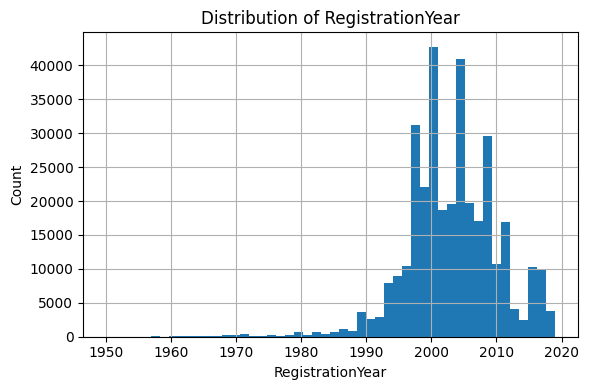

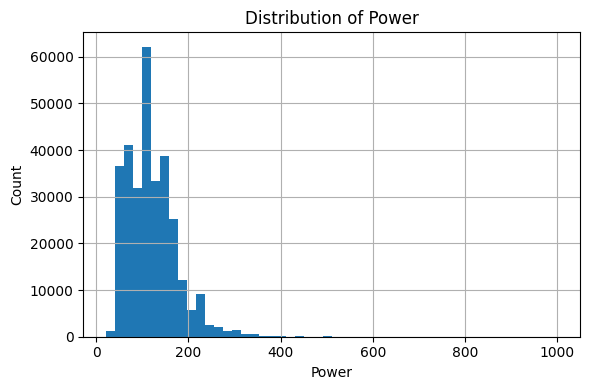

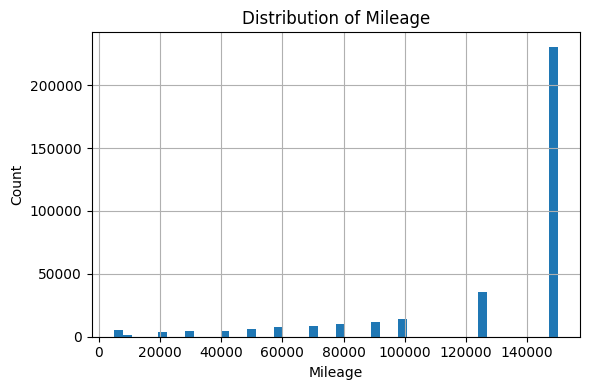

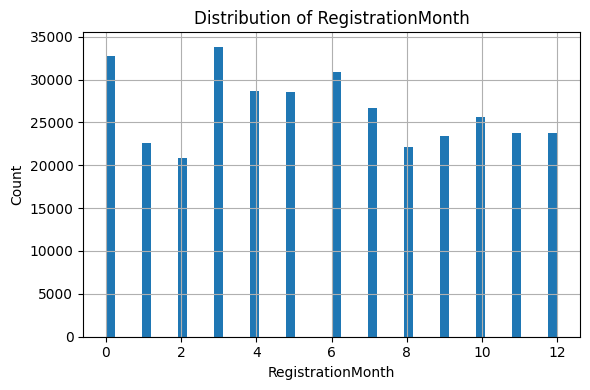

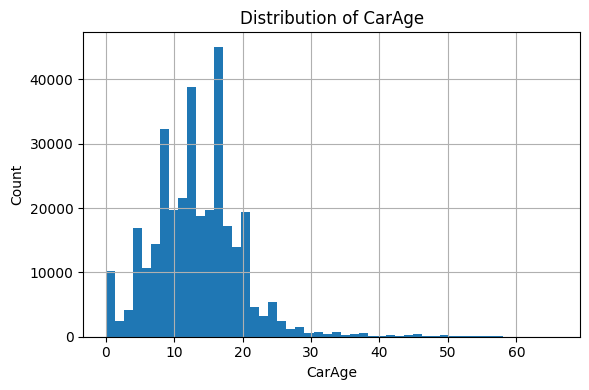

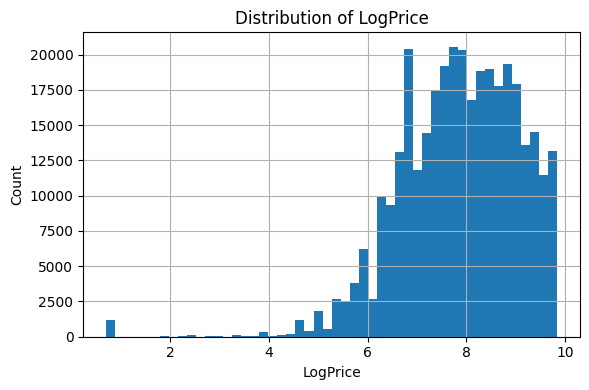

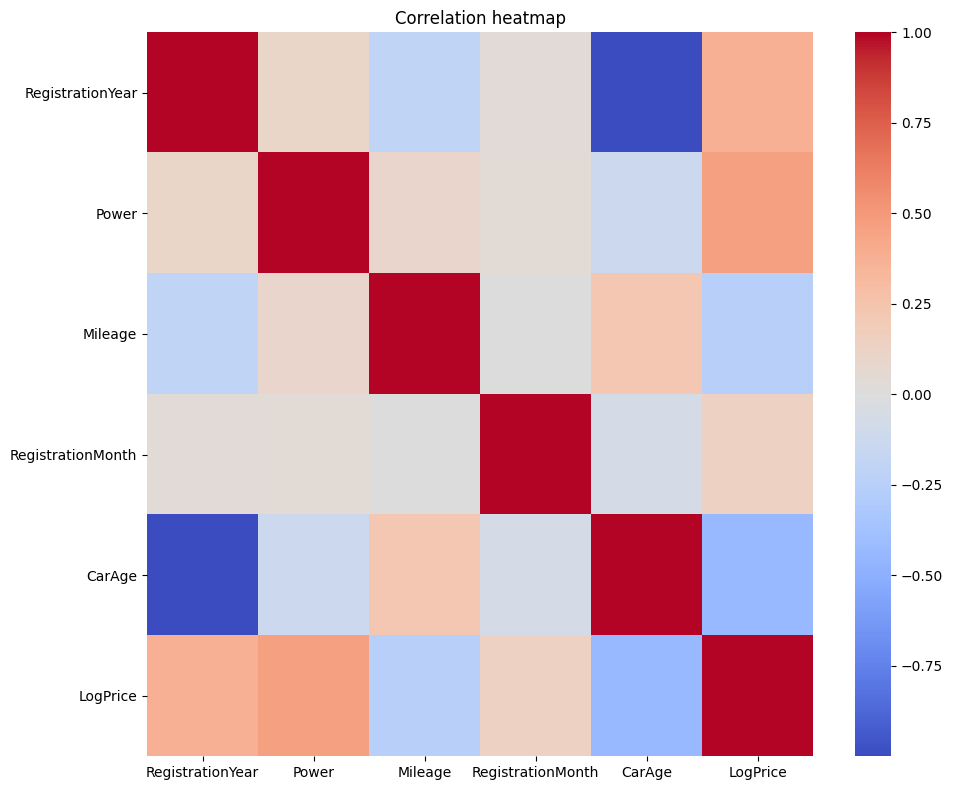

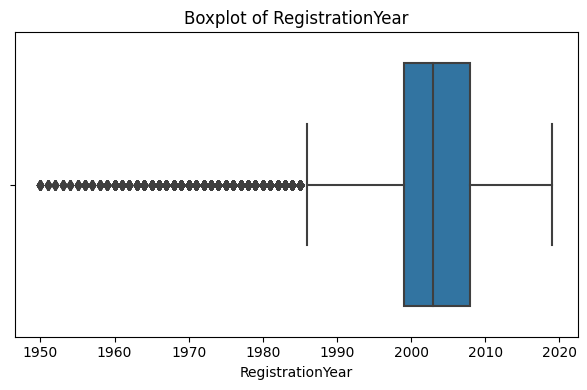

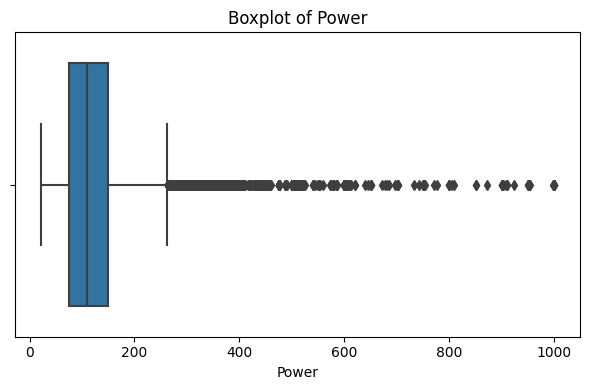

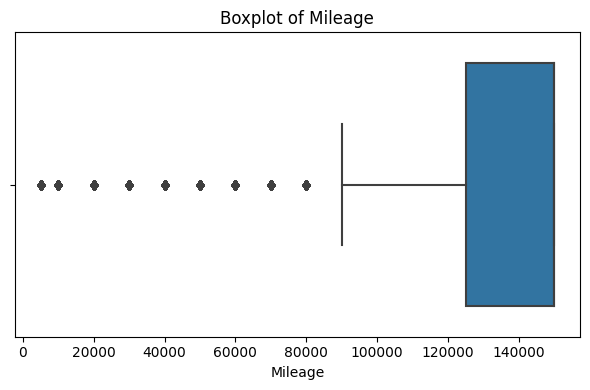

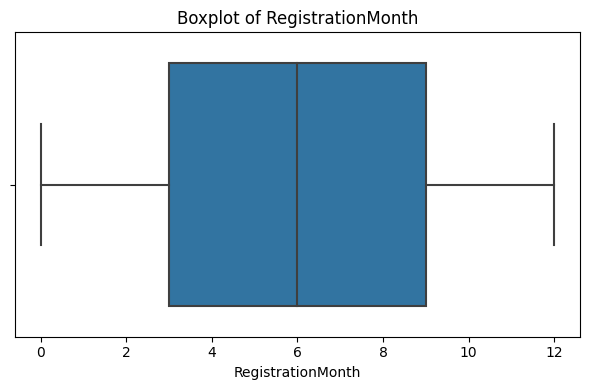

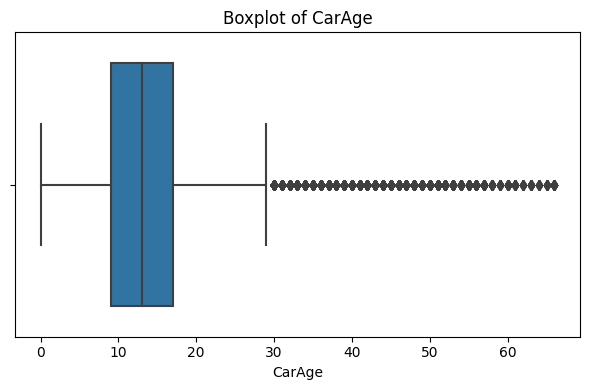

In [13]:
# ---------------------------------------------------------
# Prepare dataset for modeling
# ---------------------------------------------------------

# Use the log-transformed target created during feature engineering
TARGET_COL = "LogPrice"

# Remove rows where the engineered target is missing
# (Models cannot train on missing target values)
df_feat = df_feat.dropna(subset=[TARGET_COL])

# ---------------------------------------------------------
# Drop raw date columns
# ---------------------------------------------------------
# These columns were only needed to compute CarAge.
# Keeping them would add unnecessary noise and complexity.
drop_for_model = ["DateCrawled", "DateCreated", "LastSeen", "Price"]
for col in drop_for_model:
    if col in df_feat.columns:
        df_feat = df_feat.drop(columns=[col])

# ---------------------------------------------------------
# Identify numeric and categorical feature columns
# ---------------------------------------------------------

# Categorical features: dtype == object
categorical_cols = df_feat.select_dtypes(include=["object"]).columns.tolist()

# Numeric features: everything else except the target
numeric_cols = df_feat.select_dtypes(exclude=["object"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET_COL]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# ---------------------------------------------------------
# Visualize distributions and relationships
# ---------------------------------------------------------

# Histograms for numeric features + target
plot_distributions(df_feat, numeric_cols, target_col=TARGET_COL)

# Correlation heatmap for numeric features + target
plot_correlations(df_feat, numeric_cols, target_col=TARGET_COL)

# Boxplots to inspect outliers in numeric features
plot_outliers(df_feat, numeric_cols)

## Model training

In [14]:
# ---------------------------------------------------------
# Split features and target for modeling
# ---------------------------------------------------------

# X contains all features except the log-transformed target
X = df_feat.drop(columns=[TARGET_COL])

# y contains only the log-transformed target
y = df_feat[TARGET_COL]

# Train/validation split for model evaluation
# - 20% of the data is held out for validation
# - random_state ensures reproducibility
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# Preprocessing for Linear Regression
# ---------------------------------------------------------
# Linear models require:
# - No missing values
# - One-hot encoding for categorical variables
#
# This pipeline:
# - Imputes numeric values with the median
# - Imputes categorical values with the most frequent category
# - One-hot encodes categorical variables
linear_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_cols),
    ]
)

# ---------------------------------------------------------
# Preprocessing for Tree-Based Models
# ---------------------------------------------------------
# Tree models (Decision Tree, Random Forest, LightGBM) require:
# - No missing values
# - Ordinal encoding for categorical variables
#
# This pipeline:
# - Imputes numeric values with the median
# - Imputes categorical values with the most frequent category
# - Ordinal-encodes categories, assigning unseen categories to -1
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
        ]), numeric_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1
            )),
        ]), categorical_cols),
    ]
)

In [21]:
%%time
pipe_lr, rmse_lr = train_and_evaluate(
    "Linear Regression",
    LinearRegression(),
    linear_preprocessor
)
# ---------------------------------------------------------
# Train + evaluate Linear Regression (timed externally)
# ---------------------------------------------------------

# %%time measures the total execution time of this cell.
# This includes:
# - Building the pipeline
# - Fitting the model on X_train, y_train
# - Predicting on X_valid
# - Computing and printing RMSE

%timeit pipe_lr.predict(X_valid)
# ---------------------------------------------------------
# Measure prediction speed
# ---------------------------------------------------------

# %timeit runs pipe_lr.predict(X_valid) many times and reports
# the average execution time.
# This helps compare inference speed across models.


=== Linear Regression ===
RMSE: 6032.31
96.3 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 8.62 s, sys: 989 ms, total: 9.61 s
Wall time: 9.02 s


In [22]:
%%time
pipe_rf, rmse_rf = train_and_evaluate(
    "Random Forest",
    RandomForestRegressor(
        n_estimators=200,   # Number of trees in the forest
        max_depth=20,       # Limit depth to control overfitting
        n_jobs=-1,          # Use all CPU cores for faster training
        random_state=42     # Ensures reproducible results
    ),
    tree_preprocessor       # Ordinal-encoding + imputation for tree models
)
# ---------------------------------------------------------
# Train + evaluate Random Forest Regressor (timed externally)
# ---------------------------------------------------------

# %%time measures the total execution time of this cell.
# This includes:
# - Building the preprocessing + model pipeline
# - Fitting the Random Forest on the training data
# - Predicting on the validation set
# - Computing and printing RMSE

%timeit pipe_rf.predict(X_valid)
# ---------------------------------------------------------
# Measure prediction speed
# ---------------------------------------------------------

# %timeit repeatedly runs pipe_rf.predict(X_valid) and reports
# the average inference time.
# This helps compare prediction latency across models.


=== Random Forest ===
RMSE: 1739.65
1.77 s ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: user 2min 25s, sys: 747 ms, total: 2min 26s
Wall time: 1min 14s


In [23]:
%%time
pipe_lgbm, rmse_lgbm = train_and_evaluate(
    "LightGBM",
    LGBMRegressor(
        n_estimators=500,     # Number of boosting iterations
        learning_rate=0.05,   # Smaller LR → slower but more accurate training
        max_depth=-1,         # -1 means "no limit" (tree grows as needed)
        num_leaves=31,        # Controls model complexity; 31 is a common default
        random_state=42,      # Ensures reproducibility
        n_jobs=-1             # Use all CPU cores for faster training
    ),
    tree_preprocessor          # Ordinal-encoding + imputation for tree models
)
# ---------------------------------------------------------
# Train + evaluate LightGBM Regressor (timed externally)
# ---------------------------------------------------------

# %%time measures the total execution time of this cell.
# This includes:
# - Building the preprocessing + model pipeline
# - Fitting the LightGBM model
# - Predicting on the validation set
# - Computing and printing RMSE
#
# LightGBM is typically:
# - Faster than Random Forest
# - Better at handling large feature spaces
# - Stronger at capturing nonlinear relationships

%timeit pipe_lgbm.predict(X_valid)
# ---------------------------------------------------------
# Measure prediction speed
# ---------------------------------------------------------

# %timeit repeatedly runs pipe_lgbm.predict(X_valid) and reports
# the average inference time.
# LightGBM is usually extremely fast at prediction.


=== LightGBM ===
RMSE: 1860.86
987 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: user 34.8 s, sys: 0 ns, total: 34.8 s
Wall time: 17.7 s


In [25]:
%%time
pipe_tree, rmse_tree = train_and_evaluate(
    "Decision Tree",
    DecisionTreeRegressor(
        max_depth=12,          # Limit tree depth to reduce overfitting
        min_samples_leaf=5,    # Minimum samples per leaf for smoother splits
        random_state=42        # Ensures reproducible results
    ),
    tree_preprocessor          # Ordinal-encoding + imputation for tree models
)
# ---------------------------------------------------------
# Train + evaluate Decision Tree Regressor (timed externally)
# ---------------------------------------------------------

# %%time measures the total execution time of this cell.
# This includes:
# - Building the pipeline
# - Fitting the Decision Tree model
# - Predicting on the validation set
# - Computing and printing RMSE

%timeit pipe_tree.predict(X_valid)
# ---------------------------------------------------------
# Measure prediction speed
# ---------------------------------------------------------

# %timeit repeatedly runs pipe_tree.predict(X_valid) and reports
# the average inference time.
# Useful for comparing model latency across algorithms.


=== Decision Tree ===
RMSE: 2084.61
87.5 ms ± 872 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 8.3 s, sys: 0 ns, total: 8.3 s
Wall time: 8.3 s


## Model analysis

In [26]:
# ---------------------------------------------------------
# Build a comparison table of model RMSE scores
# ---------------------------------------------------------

# Construct a list of model results.
# LightGBM is included only if LIGHTGBM_AVAILABLE is True.
results_df = pd.DataFrame([
    ["Linear Regression", rmse_lr],
    ["Decision Tree", rmse_tree],
    ["Random Forest", rmse_rf],
    ["LightGBM", rmse_lgbm] if LIGHTGBM_AVAILABLE else None
]).dropna()

# Assign column names for clarity
results_df.columns = ["Model", "RMSE"]

# Sort models by RMSE (lower = better)
results_df.sort_values("RMSE")

,Model,RMSE
2,Random Forest,1739.649665
3,LightGBM,1860.857507
1,Decision Tree,2084.612685
0,Linear Regression,6032.308258


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed